In [1]:
import freud
import gsd
import gsd.pygsd
import gsd.hoomd
import signac
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import cycler
from scipy.stats import linregress
from matplotlib import cm
from pylab import *
from matplotlib.ticker import ScalarFormatter

In [2]:
def atom_type_pos(snap, atom_type):
    if not isinstance(atom_type, list):
        atom_type = [atom_type]
    positions = []
    for atom in atom_type:
        indices = np.where(snap.particles.typeid == snap.particles.types.index(atom))
        positions.append(snap.particles.position[indices])
    return np.concatenate(positions)

def msd_from_gsd(gsdfile, start=-10, stop=-1, atom_type='ss', msd_mode = "window"):
    f = gsd.pygsd.GSDFile(open(gsdfile, "rb"))
    trajectory = gsd.hoomd.HOOMDTrajectory(f)
    positions = []
    for frame in trajectory[start:stop]:
        if atom_type == 'all':
            atom_positions = frame.particles.position[:]
        else:
            atom_positions = atom_type_pos(frame, atom_type)
        positions.append(atom_positions)
    msd = freud.msd.MSD(box=trajectory[-1].configuration.box, mode=msd_mode)
    msd.compute(positions)
    f.close()
    return(msd.msd) # This is retruning an array of numbers (the y-axis on the msd plot)

In [3]:
project = signac.get_project("ptb7-project")

In [73]:
state_dict = {'size': 'small', 'process': 'quench'}
              #"density": 0.8, "molecule": "PTB7_5mer_smiles"}

job_list = project.find_jobs(state_dict)
for job in job_list:
    msd = msd_from_gsd(job.fn('trajectory.gsd'))
    tspf = job.sp['n_steps'] / 100
    y = msd[-15:]
    x = np.arange(0, len(y), 1) * tspf
    slope, intercept, r_value, p_value, std_err = linregress(x, y)
    job.doc['msd_slope'] = slope
    job.doc['msd_slope_r2'] = r_value
    #print("slope of", job, "is:")
    #print(slope)
    

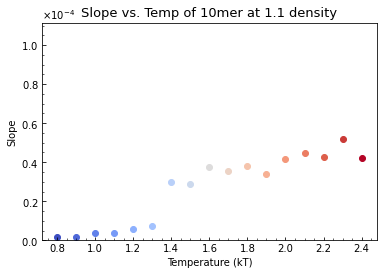

In [23]:
state_dict = {'size': 'small', 'process': 'quench', 
              "density": 1.1, "molecule":"PTB7_10mer_smiles" }

job_list = project.find_jobs(state_dict)


if job.sp['molecule'] == "PTB7_5mer_smiles":
    mol = "5mer"
if job.sp['molecule'] == "PTB7_10mer_smiles":
    mol = "10mer"
if job.sp['molecule'] == "PTB7_15mer_smiles":
    mol = "15mer"


fig = plt.figure()
ax = plt.subplot(111)
state_dict['kT_reduced.$lt'] = 2.5
color = plt.cm.coolwarm(np.linspace(0, 1, len(job_list)))

mpl.rcParams['axes.prop_cycle'] = plt.cycler('color', color)

for temp,job in job_list.groupby('kT_reduced'):
    job = list(job)[0]
    msd = msd_from_gsd(job.fn('trajectory.gsd'))
    slope = job.doc['msd_slope']
    x2=job.sp["kT_reduced"]
    y2=slope
    plt.scatter(x2,y2, label=temp)
    plt.ylim(0, 0.0001114)
    ax.minorticks_on()
    ax.tick_params(axis='both', which='both', direction='in', labelsize=10)
    plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0), useMathText=True)


plt.title("Slope vs. Temp of %s at %s density" % (mol, job.sp['density']), fontsize=13 )
plt.xlabel("Temperature (kT)")
plt.ylabel("Slope")
plt.show()

In [87]:
def make_me_a_graph(state_dict):

    job_list = project.find_jobs(state_dict)
    
    fig = plt.figure()
    ax = plt.subplot(111)
    state_dict['kT_reduced.$lt'] = 2.5
    color = plt.cm.coolwarm(np.linspace(0, 1, len(job_list)))
    
    mpl.rcParams['axes.prop_cycle'] = plt.cycler('color', color)
    
    for temp,job in job_list.groupby('kT_reduced'):

        
        job = list(job)[0]
        msd = msd_from_gsd(job.fn('trajectory.gsd'))
        slope = job.doc['msd_slope']
        x2=job.sp["kT_reduced"]
        y2=slope
        plt.scatter(x2,y2, label=temp)
        plt.ylim(0, 0.00014)
        ax.minorticks_on()
        ax.tick_params(axis='both', which='both', direction='in', labelsize=10)
        plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0), useMathText=True)

    if job.sp['molecule'] == "PTB7_5mer_smiles":
        mol = "5mer"
    if job.sp['molecule'] == "PTB7_10mer_smiles":
        mol = "10mer"
    if job.sp['molecule'] == "PTB7_15mer_smiles":
        mol = "15mer"
    plt.title("Slope vs. Temp of PTB7 %s at %s density" % (mol, job.sp['density']), fontsize=11.75 )
    plt.xlabel("Temperature (kT)")
    plt.ylabel("Slope")
    plt.show()

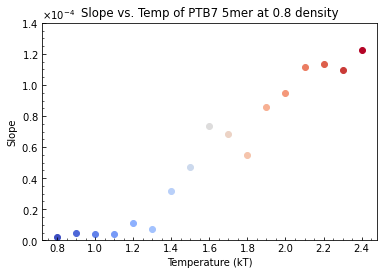

In [88]:
make_me_a_graph(state_dict = {'size': 'small', 'process': 'quench', 
                              "density": 0.8, "molecule":"PTB7_5mer_smiles" })

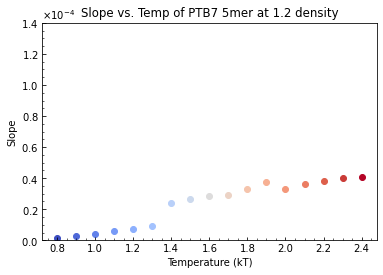

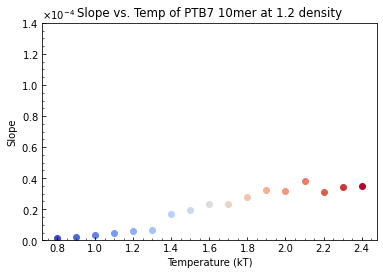

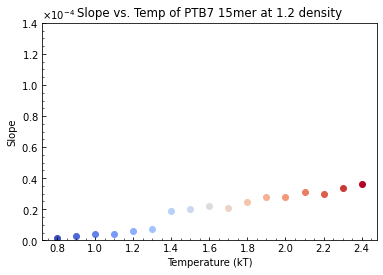

In [95]:
make_me_a_graph(state_dict = {'size': 'small', 'process': 'quench', 
                              "density": 1.2, "molecule":"PTB7_5mer_smiles" })
make_me_a_graph(state_dict = {'size': 'small', 'process': 'quench', 
                              "density": 1.2, "molecule":"PTB7_10mer_smiles" })
make_me_a_graph(state_dict = {'size': 'small', 'process': 'quench', 
                              "density": 1.2, "molecule":"PTB7_15mer_smiles" })

In [7]:
#print(job.sp)

In [8]:
#counting # of jobs for scatter plot 
#for index,job in enumerate(job_list):    
#    x2=job.sp["kT_reduced"]
#    y2=slope
#    print(index, x2, y2)


#to get hex from colormap
#from pylab import *
#cmap = cm.get_cmap('seismic', 17)    # PiYG
#for i in range(cmap.N):
#    rgb = cmap(i)[:3] # will return rgba, we take only first 3 so we get rgb
#    print(matplotlib.colors.rgb2hex(rgb))